In [1]:
import os
import glob
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_formats = ["svg"]
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 5
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)

PATH_DATA = "data"
PATH_CMD_OUTPUT = "output"

Metadata for RBP knockdown RNA-seq datasets.

In [2]:
kd_rnaseq_all = pd.concat(
    [
        pd.read_excel(
            os.path.join(PATH_DATA, "KD_RNAseq_metadata.xlsx"),
            sheet_name="HepG2",
            skiprows=1,
        ),
        pd.read_excel(
            os.path.join(PATH_DATA, "KD_RNAseq_metadata.xlsx"),
            sheet_name="K562",
            skiprows=1,
        ),
    ]
)
kd_rnaseq_all.index = range(len(kd_rnaseq_all))

In [3]:
RBP_LIST = """
CPSF6
CPSF7
DDX1
DDX3X
DDX5
EIF4A3
FIP1L1
FUS
G3BP1
HNRNPA0
HNRNPA2B1
HNRNPH1
HNRNPL
HNRNPM
HSPD1
IGF2BP1
NONO
PABPC1
PES1
PUF60
RBM14
SFPQ
    """.strip().split(
    "\n"
)
RBP_MOTIFS_LIST = {"HNRNPL", "HNRNPM", "PUF60"}

In [4]:
kd_rnaseq_meta = kd_rnaseq_all[kd_rnaseq_all["RBP"].isin(RBP_LIST)]
kd_rnaseq_meta.index = range(len(kd_rnaseq_meta))
kd_rnaseq_meta = kd_rnaseq_meta[kd_rnaseq_meta["RBP"].isin(RBP_MOTIFS_LIST)]
kd_rnaseq_meta

,RBP,Alias,Cell line,Knockdown ENCODE accession ID,Control ENCODE accession ID,Number of reads (Knockdown Rep1),Number of reads (Knockdown Rep2),Number of reads (Control Rep1),Number of reads (Control Rep2),Number of significant differentially expressed genes,SE,MXE,A5SS,A3SS,RI,TANDEMUTR
11,HNRNPL,HNRNPL,HepG2,ENCSR155BMF,ENCSR042QTH,42016602,47693432,93841724,47678806,2291,538,172,21,27,54,273
12,HNRNPM,HNRNPM,HepG2,ENCSR995JMS,ENCSR067GHD,39352936,44431348,33480268,56141062,1361,253,43,5,9,15,1
18,PUF60,PUF60,HepG2,ENCSR648BSC,ENCSR042QTH,41974082,44291328,93841724,47678806,4360,2471,622,75,303,224,392
32,HNRNPL,HNRNPL,K562,ENCSR563YIS,ENCSR031RRO,53335788,57397602,71090814,69192056,416,667,90,12,18,31,122
33,HNRNPM,HNRNPM,K562,ENCSR746NIM,ENCSR032YMP,34653816,36071934,65661114,54069404,1610,251,26,5,6,17,25
39,PUF60,PUF60,K562,ENCSR558XNA,ENCSR620PUP,117970110,59882314,62015428,148536488,1841,3422,849,86,290,277,90


Alignment files for analysis "ENCODE4 v1.2.1 GRCh38 V29" were downloaded for each RBP knockdown RNA-seq experiment. rMATS was then run for each RBP knockdown experiment and for 99xGly cell lines -DOX vs. +DOX.

Helper function to format genomic ranges around exons.

In [5]:
EXON_BASES = 100
INTRON_BASES = 250


def genomic_range(row):
    def range_format(ch, start, end, strand):
        return f"{ch}:{start}-{end}:{strand}"

    ch, strand = row["chr"], row["strand"]
    if strand == "+":
        row["rangeES"] = range_format(
            ch,
            row["exonStart_0base"] - INTRON_BASES,
            row["exonStart_0base"] + EXON_BASES,
            strand,
        )
        row["rangeEE"] = range_format(
            ch,
            row["exonEnd"] - EXON_BASES,
            row["exonEnd"] + INTRON_BASES,
            strand,
        )
        row["rangeUE"] = range_format(
            ch,
            row["upstreamEE"] - EXON_BASES,
            row["upstreamEE"] + INTRON_BASES,
            strand,
        )
        row["rangeDS"] = range_format(
            ch,
            row["downstreamES"] - INTRON_BASES,
            row["downstreamES"] + EXON_BASES,
            strand,
        )
    else:
        row["rangeES"] = range_format(
            ch,
            row["exonEnd"] - EXON_BASES,
            row["exonEnd"] + INTRON_BASES,
            strand,
        )
        row["rangeEE"] = range_format(
            ch,
            row["exonStart_0base"] - INTRON_BASES,
            row["exonStart_0base"] + EXON_BASES,
            strand,
        )
        row["rangeUE"] = range_format(
            ch,
            row["downstreamES"] - INTRON_BASES,
            row["downstreamES"] + EXON_BASES,
            strand,
        )
        row["rangeDS"] = range_format(
            ch,
            row["upstreamEE"] - EXON_BASES,
            row["upstreamEE"] + INTRON_BASES,
            strand,
        )
    return row

Load results from rMATS.

In [6]:
def load_rmats_result(file, n_background=2000, inc_level_difference=0.05, min_reads=50):
    se = pd.read_csv(file, sep="\t")
    se["reads"] = (
        se[["IJC_SAMPLE_1", "SJC_SAMPLE_1", "IJC_SAMPLE_2", "SJC_SAMPLE_2"]]
        .applymap(lambda x: sum(map(int, x.split(","))))
        .sum(axis=1)
    )

    se["subset"] = None
    # subset up- and down-regulated exons
    se.loc[
        (se["FDR"] < 0.05)
        & (se["IncLevelDifference"] > inc_level_difference)
        & (se["reads"] > min_reads),
        "subset",
    ] = "UP"
    se.loc[
        (se["FDR"] < 0.05)
        & (se["IncLevelDifference"] < -inc_level_difference)
        & (se["reads"] > min_reads),
        "subset",
    ] = "DOWN"
    # subset background exons, randomly sample if there are too many
    se.loc[
        (se["FDR"] > 0.05)
        & (abs(se["IncLevelDifference"]) < 0.01)
        & (se["reads"] > min_reads),
        "subset",
    ] = "BACKGROUND"
    background = se.loc[
        (se["subset"] == "BACKGROUND")
        & (~se["GeneID"].isin(se.loc[se["subset"].isin(("UP", "DOWN")), "GeneID"]))
    ]
    if len(background) > n_background:
        background = background.sample(n=n_background)

    se = pd.concat(
        [se[se["subset"] == "UP"], se[se["subset"] == "DOWN"], background], axis=0
    )
    print(se["subset"].value_counts())

    se = se.apply(genomic_range, axis=1)
    return se

In [7]:
# load rMATS result and save to pickle for RBP knockdown experiments
PATH_KD_RNASEQ_EXONS = os.path.join(PATH_CMD_OUTPUT, "exons_kd_rnaseq.pkl")
if os.path.exists(PATH_KD_RNASEQ_EXONS):
    with open(PATH_KD_RNASEQ_EXONS, "rb") as f:
        dfs_se = pickle.load(f)
else:
    dfs_se = {}
    for i in kd_rnaseq_meta.index:
        dfs_se[i] = load_rmats_result(f"out_{i}/SE.MATS.JC.txt")
    with open(PATH_KD_RNASEQ_EXONS, "wb") as f:
        pickle.dump(dfs_se, f)

# load rMATS result and save to pickle for 99xGly cell lines -DOX vs. +DOX
PATH_99XGLY_EXONS = os.path.join(PATH_CMD_OUTPUT, "exons_99xGly.pkl")
if os.path.exists(PATH_99XGLY_EXONS):
    with open(PATH_99XGLY_EXONS, "rb") as f:
        polyGly99_se = pickle.load(f)
else:
    print("99xGly HEK293T")
    polyGly99_se = load_rmats_result(
        "out_99xGly/SE.MATS.JC.txt", inc_level_difference=0.01
    )
    with open(PATH_99XGLY_EXONS, "wb") as f:
        pickle.dump(polyGly99_se, f)

In [8]:
polyGly99_se

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,...,FDR,IncLevel1,IncLevel2,IncLevelDifference,reads,subset,rangeES,rangeEE,rangeUE,rangeDS
1167,1363,ENSG00000158423.16,RIBC1,chrX,+,53428282,53428627,53428002,53428084,53429853,...,0.039838,"1.0,1.0,1.0","0.8,0.8,0.9",0.167,157,UP,chrX:53428032-53428382:+,chrX:53428527-53428877:+,chrX:53427984-53428334:+,chrX:53429603-53429953:+
2020,2329,ENSG00000100429.17,HDAC10,chr22,-,50248661,50248751,50248224,50248472,50249102,...,0.038368,"1.0,1.0,1.0","0.926,0.878,0.882",0.105,154,UP,chr22:50248651-50249001:-,chr22:50248411-50248761:-,chr22:50248852-50249202:-,chr22:50248372-50248722:-
2165,2482,ENSG00000075234.16,TTC38,chr22,+,46287072,46287154,46285240,46285279,46288422,...,0.043877,"1.0,1.0,1.0","0.929,0.971,0.989",0.037,2299,UP,chr22:46286822-46287172:+,chr22:46287054-46287404:+,chr22:46285179-46285529:+,chr22:46288172-46288522:+
2754,3139,ENSG00000133424.20,LARGE1,chr22,-,33337645,33337801,33316084,33316248,33381918,...,0.040562,"1.0,1.0,1.0","0.964,0.982,0.992",0.021,1415,UP,chr22:33337701-33338051:-,chr22:33337395-33337745:-,chr22:33381668-33382018:-,chr22:33316148-33316498:-
3225,3688,ENSG00000099991.17,CABIN1,chr22,+,24119366,24119698,24113565,24113748,24134301,...,0.043877,"1.0,1.0,1.0","0.968,0.99,0.995",0.016,5490,UP,chr22:24119116-24119466:+,chr22:24119598-24119948:+,chr22:24113648-24113998:+,chr22:24134051-24134401:+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97799,112162,ENSG00000196739.14,COL27A1,chr9,+,114301283,114301319,114301071,114301125,114301444,...,0.999218,"1.0,1.0,0.989","1.0,0.986,1.0",0.001,714,BACKGROUND,chr9:114301033-114301383:+,chr9:114301219-114301569:+,chr9:114301025-114301375:+,chr9:114301194-114301544:+
10953,12543,ENSG00000079134.11,THOC1,chr18,-,264025,264092,260185,260304,265302,...,0.527893,"1.0,1.0,1.0","1.0,0.988,1.0",0.004,3169,BACKGROUND,chr18:263992-264342:-,chr18:263775-264125:-,chr18:265052-265402:-,chr18:260204-260554:-
77505,88652,ENSG00000077044.10,DGKD,chr2,+,233457220,233457328,233456898,233456995,233458283,...,0.349013,"0.997,0.989,1.0","1.0,1.0,1.0",-0.005,2529,BACKGROUND,chr2:233456970-233457320:+,chr2:233457228-233457578:+,chr2:233456895-233457245:+,chr2:233458033-233458383:+
103209,118379,ENSG00000162408.10,NOL9,chr1,-,6550395,6550615,6533279,6533441,6554106,...,0.999218,"1.0,1.0,1.0","1.0,0.977,1.0",0.008,4004,BACKGROUND,chr1:6550515-6550865:-,chr1:6550145-6550495:-,chr1:6553856-6554206:-,chr1:6533341-6533691:-


In [19]:
for k, df in list(dfs_se.items()) + [("99xGly HEK293T", polyGly99_se)]:
    if k in kd_rnaseq_meta.index:
        print(" ".join(kd_rnaseq_meta.loc[k][["Cell line", "RBP"]]))
    else: print(k)
    print(df["subset"].value_counts())

HepG2 HNRNPL
BACKGROUND    2000
UP             545
DOWN           388
Name: subset, dtype: int64
HepG2 HNRNPM
BACKGROUND    2000
UP             336
DOWN           322
Name: subset, dtype: int64
HepG2 PUF60
DOWN          2619
BACKGROUND    2000
UP             804
Name: subset, dtype: int64
K562 HNRNPL
BACKGROUND    2000
DOWN           669
UP             510
Name: subset, dtype: int64
K562 HNRNPM
BACKGROUND    2000
UP             373
DOWN           312
Name: subset, dtype: int64
K562 PUF60
DOWN          3424
BACKGROUND    2000
UP             874
Name: subset, dtype: int64
99xGly HEK293T
BACKGROUND    2000
UP             130
DOWN            17
Name: subset, dtype: int64


Write genomic ranges for control and differentially spliced exons to .txt files for RBPmap to predict motifs.

In [20]:
RBPMAP_LIMIT = 5000

se_ranges = {}
for i, se in list(dfs_se.items()) + [("polyGly99", polyGly99_se)]:
    ranges = sorted(
        set(se[["rangeES", "rangeEE", "rangeUE", "rangeDS"]].values.flatten())
    )
    se_ranges[i] = ranges

    for j in range((len(ranges) // 5000) + 1):
        with open(
            os.path.join(PATH_CMD_OUTPUT, f"genomic_ranges_{i}_{j}.txt"), "w"
        ) as f:
            f.write("\n".join(ranges[j * 5000 : (j + 1) * 5000]))

RBPmap was run for each file. For RBP knockdown experiments, the motif for that RBP was predicted. For 99xGly cell lines -DOX vs. +DOX, all motifs were predicted.

In [21]:
def load_rbpmap_predictions(files):
    rows = []  # rows for each motif occurrence
    for path in sorted(set(files)):
        with open(path, "r") as f:
            table = False  # whether current line is in a table
            chr_range = ""  # genomic range and strand for current table
            protein = ""  # RBP for current table
            for line in f:
                if table:
                    if line == "\n":
                        table = False  # tables end in empty line
                    else:
                        rows.append(
                            line.replace("Sequence Position", "Sequence_Position")
                            .replace("Genomic Coordinate", "Genomic_Coordinate")
                            .split()
                            + [chr_range.split(":")[2], chr_range, protein]
                        )
                elif line.startswith("Sequence Position"):
                    table = True  # tables start with header row
                elif line.startswith("chr"):
                    chr_range = line.strip()  # genomic range info precedes table
                elif line.startswith("Protein: "):
                    protein = line.strip().split(": ")[1].split("(")[0]
    motifs = pd.DataFrame(
        rows,
        columns=[
            "Sequence Position",
            "Genomic Coordinate",
            "Motif",
            "K-mer",
            "Z-score",
            "P-value",
            "strand",
            "range",
            "RBP",
        ],
    )
    motifs["Sequence Position"] = motifs["Sequence Position"].apply(int)
    assert (
        motifs.apply(lambda r: (r["range"], r["Sequence Position"], r["RBP"]), axis=1)
        .duplicated()
        .sum()
        == 0
    )
    return motifs

In [22]:
def motifs_matrix(motifs, ranges):
    # from a df containing a list of motifs, construct a np matrix where each
    # row is genomic range, each column is a relative position in the range,
    # and each entry contains whether the motif occurs at a given relative
    # position in a given genomic range

    # map range to row index in matrix
    range2idx = dict(zip(sorted(ranges), range(len(ranges))))

    motifs_data = np.zeros((len(ranges), EXON_BASES + INTRON_BASES))
    for m in motifs.itertuples():
        idx = range2idx[m.range]
        motifs_data[idx, m._1] += 1
    motifs_data.sum()
    return range2idx, motifs_data

Load RBPmap prediction output.

In [23]:
kd_rnaseq_prediction_files = {i: {} for i in dfs_se}
polyGly_prediction_files = {}

for path in glob.glob(os.path.join(PATH_CMD_OUTPUT, "RBPmap_predictions", "*.txt")):
    with open(path, "r") as f:
        line = f.readline()
    job_name = line.strip().split(": ")[1]
    i = job_name.split("_")[2]
    if i.isnumeric() and int(i) in kd_rnaseq_prediction_files:
        kd_rnaseq_prediction_files[int(i)][job_name] = path
    elif i == "polyGly99":
        polyGly_prediction_files[job_name] = path

In [24]:
kd_rnaseq_motif_matrices = {}
for i, files in kd_rnaseq_prediction_files.items():
    motifs = load_rbpmap_predictions(files.values())
    kd_rnaseq_motif_matrices[i] = motifs_matrix(motifs, se_ranges[i])

polyGly_motifs = load_rbpmap_predictions(polyGly_prediction_files.values())
polyGly_motif_matrices = {}
for rbp in sorted(RBP_MOTIFS_LIST):
    polyGly_motif_matrices[rbp] = motifs_matrix(
        polyGly_motifs[polyGly_motifs["RBP"] == rbp], se_ranges["polyGly99"]
    )

In [25]:
polyGly_motifs

,Sequence Position,Genomic Coordinate,Motif,K-mer,Z-score,P-value,strand,range,RBP
0,81,chr10:100164265,auuagu,cucaga,2.000,2.27e-02,-,chr10:100163995-100164345:-,HNRNPA0
1,90,chr10:100164256,auuagu,auuaua,2.103,1.77e-02,-,chr10:100163995-100164345:-,HNRNPA0
2,92,chr10:100164254,uauag,uauaa,2.067,1.94e-02,-,chr10:100163995-100164345:-,HNRNPA0
3,93,chr10:100164253,auuagu,auaagu,2.359,9.16e-03,-,chr10:100163995-100164345:-,HNRNPA0
4,103,chr10:100164243,uauag,uaaag,2.067,1.94e-02,-,chr10:100163995-100164345:-,HNRNPA0
...,...,...,...,...,...,...,...,...,...
498628,263,chrX:85911098,uguaag,ugaaaa,2.265,1.18e-02,-,chrX:85911010-85911360:-,SFPQ
498629,276,chrX:85911085,uguaag,agucag,2.313,1.04e-02,-,chrX:85911010-85911360:-,SFPQ
498630,283,chrX:85911078,uguaag,uuuaag,2.410,7.98e-03,-,chrX:85911010-85911360:-,SFPQ
498631,318,chrX:85911043,uguaag,auuaau,1.783,3.73e-02,-,chrX:85911010-85911360:-,SFPQ


Helper functions to generate and plot averaged motif profiles along a given set of genomic ranges.

In [26]:
def motif_profile(range2idx, motifs_data, ranges, window=50, resample=False):
    # sum number of motifs at each position for the specified set of genomic
    # ranges in the motif matrix
    ranges = np.array(ranges)
    indices = list(map(range2idx.get, ranges))
    sum_profile = motifs_data[indices].sum(axis=0)

    if resample:
        # resample specified set of genomic ranges and generate a sum profile
        # for each sample
        resampled_sum_profiles = np.zeros((resample, motifs_data.shape[1]))
        re_ranges = np.random.choice(ranges, size=(resample, len(ranges)))
        for i, rr in enumerate(re_ranges):
            resampled_sum_profiles[i] = motifs_data[list(map(range2idx.get, rr))].sum(
                axis=0
            )

        # generate CIs by 0.025 and 0.975 quantiles of the resampled
        # distribution of sum profiles at each position
        lower = np.array(
            [
                np.quantile(resampled_sum_profiles[:, i], 0.025)
                for i in range(resampled_sum_profiles.shape[1])
            ]
        )
        upper = np.array(
            [
                np.quantile(resampled_sum_profiles[:, i], 0.975)
                for i in range(resampled_sum_profiles.shape[1])
            ]
        )

        # generate profile by taking rolling average of sum profile and
        # dividing by total number of genomic ranges specified
        # return rolling window average for lower and upper bound of CI as well
        return (
            pd.DataFrame(sum_profile)
            .iloc[:, 0]
            .rolling(window=window, center=True)
            .mean()
            .values
            / len(ranges),
            pd.DataFrame(lower)
            .iloc[:, 0]
            .rolling(window=window, center=True)
            .mean()
            .values
            / len(ranges),
            pd.DataFrame(upper)
            .iloc[:, 0]
            .rolling(window=window, center=True)
            .mean()
            .values
            / len(ranges),
        )
    return pd.DataFrame(sum_profile).iloc[:, 0].rolling(
        window=window, center=True
    ).mean().values / len(ranges)

In [30]:
def motif_enrichment_plot(axs, se, range2idx, motifs_data, xlabel=False, ylabel=False, included=True, excluded=True):
    for i, ax, key in zip(range(4), axs, ("rangeUE", "rangeES", "rangeEE", "rangeDS")):
        xvals = (
            range(-INTRON_BASES, EXON_BASES)
            if key[-1] == "S"
            else range(-EXON_BASES, INTRON_BASES)
        )

        x, y, z = motif_profile(
            range2idx, motifs_data,
            se.loc[se["subset"] == "BACKGROUND", key].values,
            resample=1000
        )
        ax.plot(xvals, x, c="k", label="unchanged", lw=0.75)
        ax.fill_between(xvals, y, z, color="k", alpha=0.2)

        if excluded:
            ax.plot(
                xvals,
                motif_profile(
                    range2idx, motifs_data, se.loc[se["subset"] == "DOWN", key].values
                ),
                label="decreased",
                lw=0.75,
                c="tab:blue"
            )

        if included:
            ax.plot(
                xvals,
                motif_profile(
                    range2idx, motifs_data, se.loc[se["subset"] == "UP", key].values
                ),
                label="increased",
                lw=0.75,
                c="tab:red"
            )
        
        if i == 0:
            if ylabel:
                ax.set_ylabel(ylabel, labelpad=2)
        else:
            ax.get_yaxis().set_visible(False)
            ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.set_xticks([])
        ax.axvline(0, ls="dotted", lw=0.75, c="k", alpha=0.5)


Text(0.01, 0.5, 'average motifs per exon')

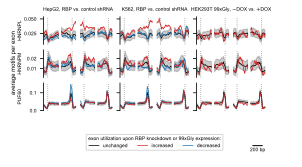

In [31]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.lines import Line2D

supfig = plt.figure(figsize=(4, 2.2))
fig, fig2, _ = supfig.subfigures(3, 1, hspace=0, height_ratios=[1.7, 0.45, 0.05])

gridspec = {
    "wspace": 0.15,
    "width_ratios": [1, 1, 0, 1, 1, 0.25, 1, 1, 0, 1, 1, 0.25, 1, 1, 0, 1, 1],
    "hspace": 0.2,
}
axs = fig.subplots(3, 17, sharex=False, sharey="row", gridspec_kw=gridspec)

for ri, rbp in enumerate(sorted(["HNRNPL", "HNRNPM", "PUF60"])):
    axs[ri][5].set_visible(False)
    axs[ri][11].set_visible(False)
    for idx in [2, 8, 14]:
        for spine in ["left", "right", "top", "bottom"]:
            axs[ri][idx].spines[spine].set_visible(False)
        axs[ri][idx].set_xticks([])
        axs[ri][idx].tick_params(axis="y", which="both", left=False, right=False)

    for j in range(3):
        if j == 0:
            idxs = kd_rnaseq_meta[
                (kd_rnaseq_meta["RBP"] == rbp)
                & (kd_rnaseq_meta["Cell line"] == "HepG2")
            ].index
            if len(idxs) == 0:
                continue
            if idxs[0] not in dfs_se:
                continue
            se = dfs_se[idxs[0]]
            range2idx, motifs_data = kd_rnaseq_motif_matrices[idxs[0]]
        elif j == 1:
            idxs = kd_rnaseq_meta[
                (kd_rnaseq_meta["RBP"] == rbp) & (kd_rnaseq_meta["Cell line"] == "K562")
            ].index
            if len(idxs) == 0:
                continue
            if idxs[0] not in dfs_se:
                continue
            se = dfs_se[idxs[0]]
            range2idx, motifs_data = kd_rnaseq_motif_matrices[idxs[0]]
        elif j == 2:
            se = polyGly99_se
            range2idx, motifs_data = polyGly_motif_matrices[rbp]
        motif_enrichment_plot(
            axs[ri][[6 * j, 6 * j + 1, 6 * j + 3, 6 * j + 4]],
            se,
            range2idx,
            motifs_data,
            ylabel=(rbp if j == 0 else False),
            excluded=se["subset"].value_counts()["DOWN"] > 100,
        )
axs[0][2].set_title("HepG2, RBP vs. control shRNA", fontdict={"fontsize": 5})
axs[0][8].set_title("K562, RBP vs. control shRNA", fontdict={"fontsize": 5})
axs[0][14].set_title("HEK293T 99xGly, $-$DOX vs. $+$DOX", fontdict={"fontsize": 5})

scalebar = AnchoredSizeBar(
    axs[-1][-1].transData, 200, "200 bp", "lower right", pad=0, frameon=False
)

ax = fig2.subplots(1, 1)
ax.add_artist(scalebar)
ax.axis("off")

fig2.legend(
    [
        Line2D([0], [0], color="k", lw=0.75),
        Line2D([0], [0], color="tab:red", lw=0.75),
        Line2D([0], [0], color="tab:blue", lw=0.75),
    ],
    [
        "unchanged",
        "increased",
        "decreased",
    ],
    loc="lower center",
    bbox_to_anchor=(0.5, 0),
    bbox_transform=ax.transAxes,
    ncol=3,
    title="exon utilization upon RBP knockdown or 99xGly expression:",
)

fig.align_ylabels(axs[:, 0])
fig.supylabel("average motifs per exon", x=0.01)

# Session info

In [28]:
import session_info

session_info.show()